This code was designed by me but AI helped me a lot to implement the functions for the cleaning . I used ChatGPT and Copilot for debugging, identifying errors, and improving efficiency.

1 STEP FILTERING: WORDS COUNT + PARTIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [ ]:
df_merged_nonfiltered = pd.read_parquet(r"/content/drive/MyDrive/AI_LLMS/merging_dataset/merged_dataset_filtered.parquet")

In [ ]:
df_merged_nonfiltered.columns

In [ ]:
df_merged_nonfiltered = df_merged_nonfiltered[df_merged_nonfiltered['speech'].notnull()]

In [ ]:
from tqdm import tqdm
tqdm.pandas()  

# Calculate the word count for each speech by counting the number of words using regex

df_merged_nonfiltered['word_count'] = df_merged_nonfiltered['speech'].progress_apply(lambda x: len(re.findall(r'\w+', x)))

100%|██████████| 7220063/7220063 [02:33<00:00, 47187.40it/s] 


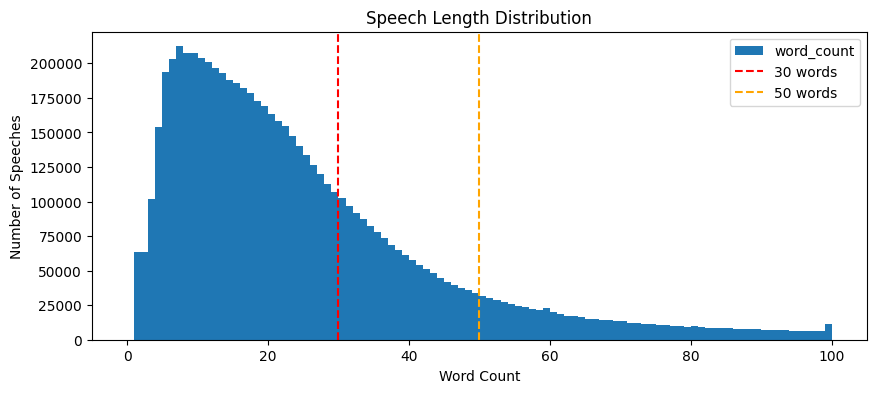

In [ ]:
df_merged_nonfiltered['word_count'].plot.hist(bins=100, figsize=(10, 4), range=(0,100))
plt.title("Speech Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Number of Speeches")
plt.axvline(30, color='red', linestyle='--', label='30 words')
plt.axvline(50, color='orange', linestyle='--', label='50 words')
plt.legend()
plt.show()

In [ ]:
df_merged_nonfiltered['word_count'].describe()

,word_count
count,7.220063e+06
mean,5.972396e+01
std,2.189140e+02
min,0.000000e+00
25%,1.100000e+01
50%,2.200000e+01
75%,3.900000e+01
max,1.205500e+04


In [ ]:
# Filter speeches to include only those with a word count of 50 or more
df_merged_nonfiltered = df_merged_nonfiltered[df_merged_nonfiltered['word_count'] >= 50]

In [ ]:
# Filter speeches by relevant parties 
filtered_parties = ['Fianna Fáil', 'Fine Gael', 'Sinn Féin']
df_filtered_parties = df_merged_nonfiltered[df_merged_nonfiltered['party_name'].isin(filtered_parties)]
print(df_filtered_parties)
print(df_filtered_parties.shape)

            speechID  memberID  partyID  constID  \
0        HIST_703801     626.0      8.0     90.0   
3        HIST_703809     626.0      8.0     90.0   
5        HIST_703807     626.0      8.0     90.0   
10       HIST_703802     781.0      9.0    167.0   
11       HIST_703810     626.0      8.0     90.0   
...              ...       ...      ...      ...   
7219779  REC_4619882       NaN      NaN      NaN   
7219961  REC_4620504       NaN      NaN      NaN   
7219971  REC_4620484       NaN      NaN      NaN   
7219985  REC_4620461       NaN      NaN      NaN   
7220030  REC_4620573       NaN      NaN      NaN   

                                                     title       date  \
0                           Transport Bill, 1949—Committee 1950-02-15   
3                           Transport Bill, 1949—Committee 1950-02-15   
5                           Transport Bill, 1949—Committee 1950-02-15   
10                          Transport Bill, 1949—Committee 1950-02-15   
11        

2 STEP FILTERING: KEYWORDS TIERS + Northen Ireland SCORE

In [ ]:
# Keyword definition for more in-depth speech level cleaning
keyword_tiers = {
    "tier1": {  # High precision: mostly exclusive to Northern Ireland context
        "party_names": r"(Sinn\s*Féin|DUP|UUP|SDLP|Alliance\s*Party|Ulster\s*Unionist|Democratic\s*Unionist)",
        "stormont": r"(Stormont|Northern\s*Ireland\s*Executive|Assembly\s*of\s*Northern\s*Ireland)",
        "identity": r"(Unionist|Loyalist|Republican|Nationalist|Orange\s*Order|peace\s*walls|Irish\s*language)",
    },
    "tier2": {  # Still NI-relevant, but broader context possible
    "agreements": r"(Good\s*Friday|Belfast\s*Agreement|St\s*Andrews|Hillsborough|Anglo-Irish|Windsor\s*Framework)",
    "conflict": r"(Troubles|Bloody\s*Sunday|paramilitary|ceasefire|decommissioning|loyalist|republican|sectarian)",
    "border": r"(six\s*counties|Irish\s*border|Northern\s*Ireland\s*border|partition|cross-border\s*cooperation|hard\s*border|soft\s*border|border\s*poll|all-island\s*economy)",
    "unification_political_integration": r"(unification\s*of\s*Ireland|united\s*Ireland|Irish\s*reunification|border\s*poll|unification\s*debates|Northern\s*Ireland\s*Assembly|post-Brexit\s*unification|democratic\s*unionist\s*position|nationalist\s*agenda|unification\s*debates)",
    "devolution_politics": r"(Stormont\s*Agreement|Northern\s*Ireland\s*Assembly|Devolution\s*of\s*Power|Executive\s*Agreements|cross-party\s*coalition|devolution\s*debates)"
    },

    "tier3": {  # Risk of false positives, needs NI context to be trusted
        "ni_brexit": r"(Northern\s*Ireland\s*Protocol|Irish\s*Sea\s*border|Brexit\s*deal\s*Northern\s*Ireland|post-Brexit\s*border|Windsor\s*Framework|cross\s*border\s*trade\s*Northern\s*Ireland|EU\s*single\s*market\s*access\s*Northern\s*Ireland|Irish\s*government\s*position\s*Northern\s*Ireland)",
        "uk_irish_relations": r"(Anglo-Irish|Westminster-Dáil|Dublin-London|cross-border\s*diplomacy|peace\s*negotiations|British\s*government\s*policy\s*on\s*Northern\s*Ireland|Dublin\s*government\s*position\s*on\s*Northern\s*Ireland)",
        "historical": r"(civil\s*rights|home\s*rule|Westminster|British\s*rule)"
    }
}


In [ ]:
import re

# Keyword weights and scores 
def score_speech(text):
    score = 0
    if not isinstance(text, str):
        return score

    # Tier weights
    tier_weights = {"tier1": 3, "tier2": 2, "tier3": 1}

    for tier, patterns in keyword_tiers.items():
        for pattern in patterns.values():
            if re.search(pattern, text, flags=re.IGNORECASE):
                score += tier_weights[tier]

    return score


In [ ]:

tqdm.pandas()


df_filtered_parties['combined_text'] = df_filtered_parties['speech'].fillna('')

# Apply scoring
df_filtered_parties['ni_score'] = df_filtered_parties['combined_text'].progress_apply(score_speech)


<ipython-input-13-a8f27b6c833b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_parties['combined_text'] = df_filtered_parties['speech'].fillna('')
100%|██████████| 988353/988353 [31:18<00:00, 526.04it/s] 
<ipython-input-13-a8f27b6c833b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_parties['ni_score'] = df_filtered_parties['combined_text'].progress_apply(score_speech)


In [ ]:
ni_score_grouped = df_filtered_parties.groupby('ni_score').size()
print(ni_score_grouped)

ni_score
0     962150
1        815
2       7418
3      12040
4        581
5       2413
6        762
7        465
8        787
9        179
10       284
11       160
12        88
13        76
14        57
15        37
16        21
17         6
18         8
19         6
dtype: int64


In [ ]:
# Filter based on score threshold
df_ni_filtered_1 =df_filtered_parties[df_filtered_parties['ni_score'] >= 1]

In [ ]:
df_ni_filtered_1.shape

(26203, 23)

<ipython-input-18-4c459e1f89a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ni_filtered_1['five_year_period'] = (df_ni_filtered_1['year'] // 5) * 5  # Create a 'five_year_period' column


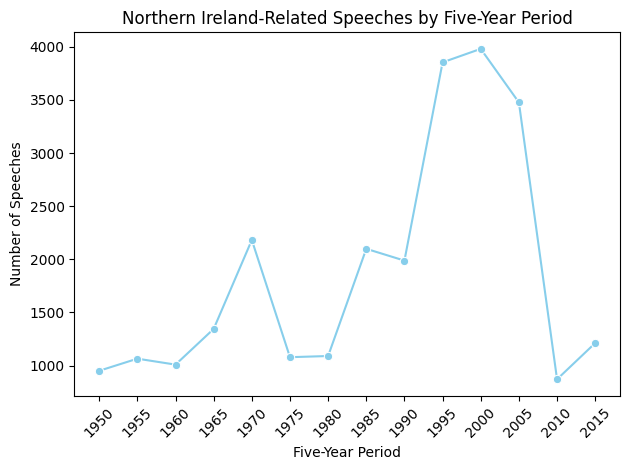

In [ ]:
# Ploting distributions of new dataset

df_ni_filtered_1['five_year_period'] = (df_ni_filtered_1['year'] // 5) * 5  # Create a 'five_year_period' column
five_year_counts = df_ni_filtered_1['five_year_period'].value_counts().sort_index()
sns.lineplot(x=five_year_counts.index.astype(str), y=five_year_counts.values, marker="o", color="skyblue")
plt.title("Northern Ireland-Related Speeches by Five-Year Period")
plt.xlabel("Five-Year Period")
plt.ylabel("Number of Speeches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

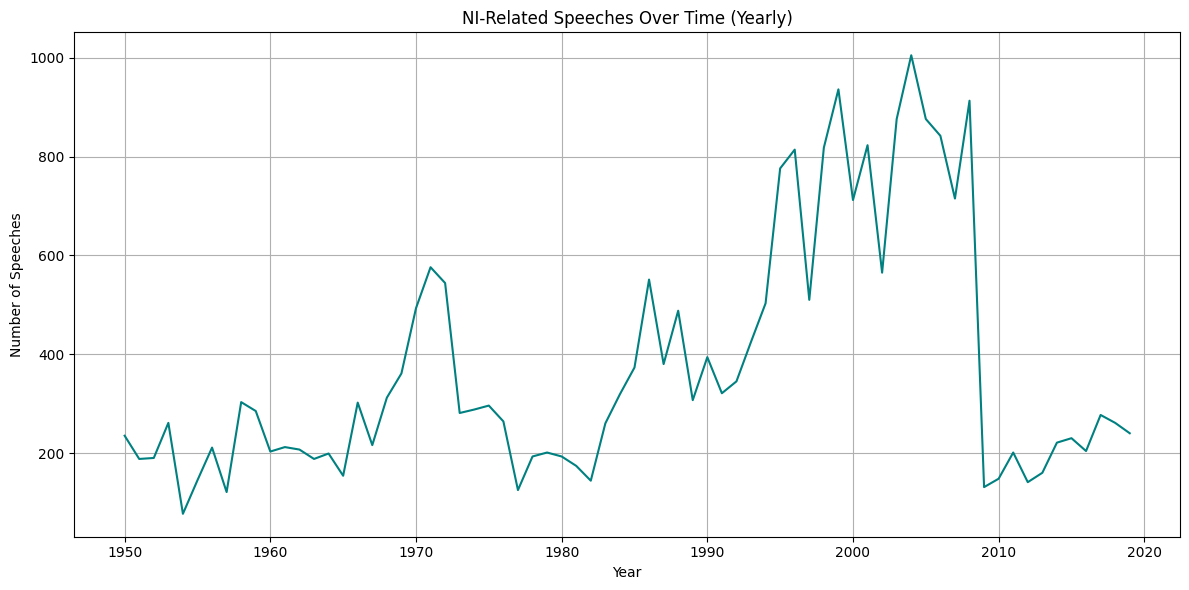

In [ ]:
yearly_counts = df_ni_filtered_1['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, color="teal")
plt.title("NI-Related Speeches Over Time (Yearly)")
plt.xlabel("Year")
plt.ylabel("Number of Speeches")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_ni_filtered_1.to_csv('/content/drive/MyDrive/df_ni_filtered_max1.csv', index=False)

3 STEP FILTERING: SENTENCE BERT applyed on ANNOTATED SPEECHS

In [ ]:
# Speechs Manually annotated as Northen Ireland Relevant
reference_ids = ['HIST_2968499', 'HIST_2775095', 'HIST_2704057', 'HIST_2280741', 'HIST_3515026', 'HIST_2804572', 'HIST_3060154', 'HIST_2820397', 'HIST_2868444', 'HIST_1524255', 'HIST_2857403', 'HIST_2790183', 'HIST_2696599', 'HIST_2962713', 'HIST_2292352', 'HIST_836100', 'HIST_3795107', 'HIST_2996999', 'HIST_3804415', 'HIST_2740907', 'HIST_3519298', 'HIST_2987675', 'REC_4735721', 'HIST_2293923', 'REC_4059492', 'HIST_1654647', 'HIST_2224676', 'HIST_3060148', 'HIST_3641685', 'HIST_3160178', 'HIST_2788225', 'HIST_1730745', 'HIST_3039263', 'HIST_2441181', 'HIST_2962680', 'HIST_3763854', 'HIST_2822679', 'HIST_2565904', 'HIST_2224671', 'HIST_2992689', 'HIST_3052591', 'HIST_2540559', 'HIST_1560042', 'HIST_2816328', 'HIST_2333635', 'HIST_1571763']

# Extract speech texts using the IDs
reference_embb = df_ni_filtered_1[df_ni_filtered_1['speechID'].isin(reference_ids)].copy()
reference_texts = reference_embb['speech'].tolist()  

# Check if all reference IDs are in df_ni_filtered_1
ids_in_df = set(df_ni_filtered_1['speechID'])
all_ids_present = set(reference_ids).issubset(ids_in_df)

if all_ids_present:
    print("All reference IDs are present in df_ni_filtered_1.")
else:
    missing_ids = set(reference_ids) - ids_in_df
    print("The following reference IDs are missing:", missing_ids)

All reference IDs are present in df_ni_filtered_1.


In [ ]:
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2')  

# Transforming the annotated speechs in embeddings
reference_embeddings = model.encode(reference_texts, convert_to_tensor=True,show_progress_bar=True)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
all_speeches = df_ni_filtered_1['speech'].tolist()

# Transforming the non annotated speechs in embeddings
all_embeddings = model.encode(all_speeches, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/819 [00:00<?, ?it/s]

In [ ]:
from torch.nn.functional import cosine_similarity
import torch

# Compute cosine similarity for each speech against all reference speeches
similarity_scores = []

for i, emb in enumerate(all_embeddings):
    sims = cosine_similarity(emb.unsqueeze(0), reference_embeddings)
    max_sim = torch.max(sims).item()
    similarity_scores.append(max_sim)


df_ni_filtered_1['ni_similarity'] = similarity_scores

<ipython-input-28-e3a9fc73623d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ni_filtered_1['ni_similarity'] = similarity_scores


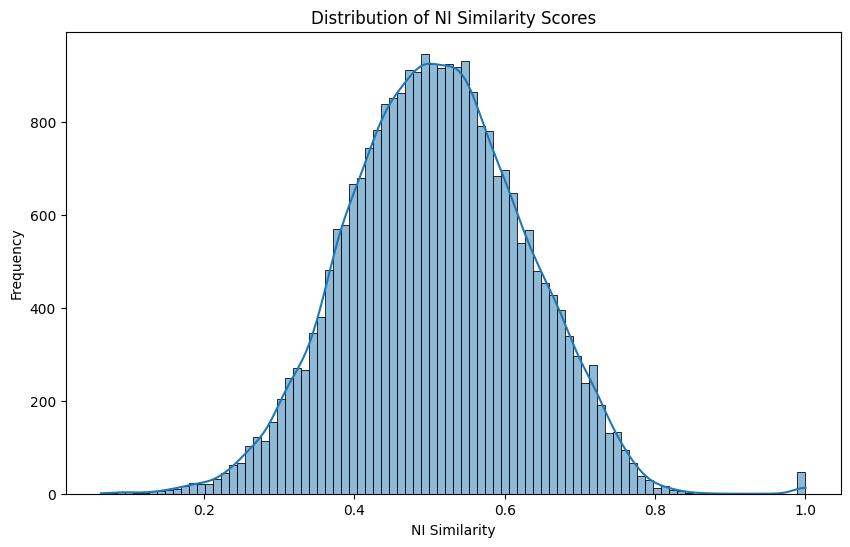

count    26203.000000
mean         0.509505
std          0.116382
min          0.063074
25%          0.429448
50%          0.508034
75%          0.588743
max          1.000000
Name: ni_similarity, dtype: float64


In [ ]:
# Distribution of NI Similarity
plt.figure(figsize=(10, 6))
sns.histplot(df_ni_filtered_1['ni_similarity'], kde=True)
plt.title('Distribution of NI Similarity Scores')
plt.xlabel('NI Similarity')
plt.ylabel('Frequency')
plt.show()



print(df_ni_filtered_1['ni_similarity'].describe())

In [ ]:
ni_06 = df_ni_filtered_1[df_ni_filtered_1['ni_similarity'] >= 0.62].copy()
ni_07 = df_ni_filtered_1[df_ni_filtered_1['ni_similarity'] >= 0.73].copy()
ni_05 = df_ni_filtered_1[df_ni_filtered_1['ni_similarity'] >= 0.51].copy()

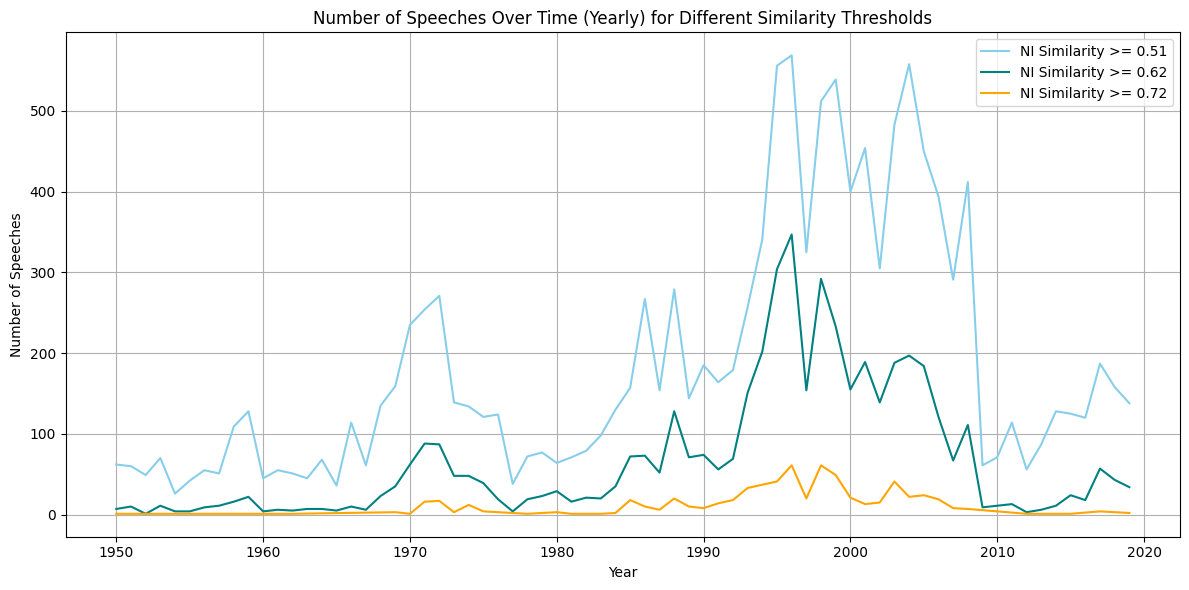

Shape of NI_05: (12948, 25)
Shape of NI_06: (4619, 25)
Shape of NI_07: (653, 25)


In [ ]:

import matplotlib.pyplot as plt
# Plotting code for NI_05, NI_06, NI_07 over time
plt.figure(figsize=(12, 6))

# Helper function to plot yearly counts
def plot_yearly_counts(df, label, color):
    yearly_counts = df['year'].value_counts().sort_index()
    sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, label=label, color=color)

# Plot yearly counts for each threshold
plot_yearly_counts(ni_05, 'NI Similarity >= 0.51', 'skyblue')
plot_yearly_counts(ni_06, 'NI Similarity >= 0.62', 'teal')
plot_yearly_counts(ni_07, 'NI Similarity >= 0.72', 'orange')


plt.title('Number of Speeches Over Time (Yearly) for Different Similarity Thresholds')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Shape comparison
print("Shape of NI_05:", ni_05.shape)
print("Shape of NI_06:", ni_06.shape)
print("Shape of NI_07:", ni_07.shape)


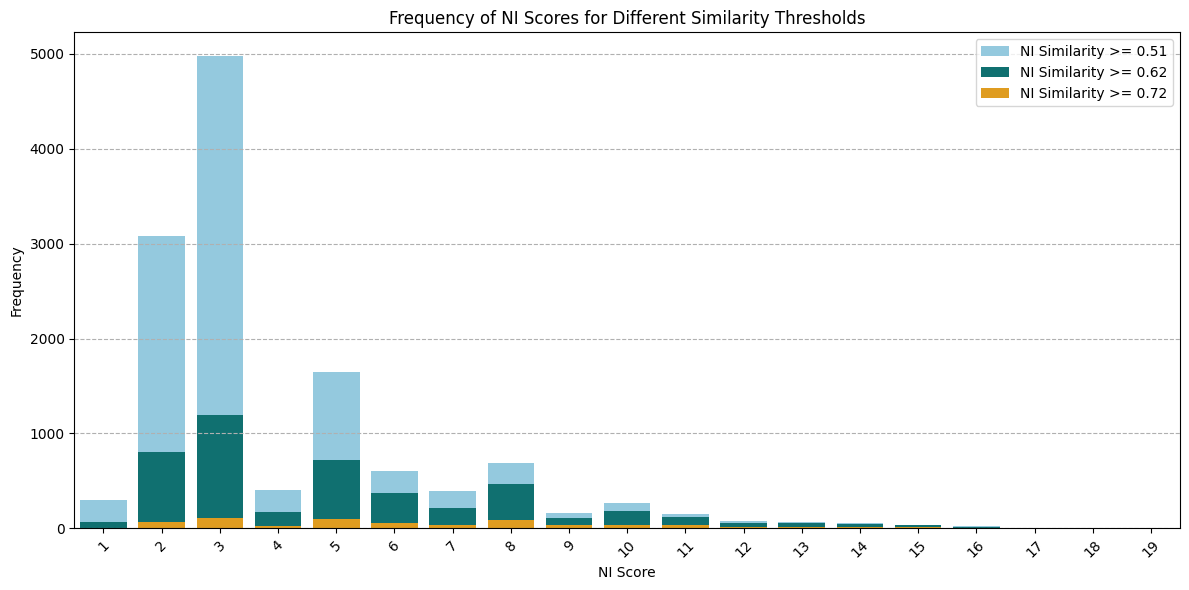

In [ ]:
# Plotting  for NI_05, NI_06, NI_07 frequency of ni_scores
plt.figure(figsize=(12, 6))

def plot_ni_score_frequency(df, label, color):
    ni_score_counts = df['ni_score'].value_counts().sort_index()
    sns.barplot(x=ni_score_counts.index, y=ni_score_counts.values, label=label, color=color)

plot_ni_score_frequency(ni_05, 'NI Similarity >= 0.51', 'skyblue')
plot_ni_score_frequency(ni_06, 'NI Similarity >= 0.62', 'teal')
plot_ni_score_frequency(ni_07, 'NI Similarity >= 0.72', 'orange')

plt.title('Frequency of NI Scores for Different Similarity Thresholds')
plt.xlabel('NI Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


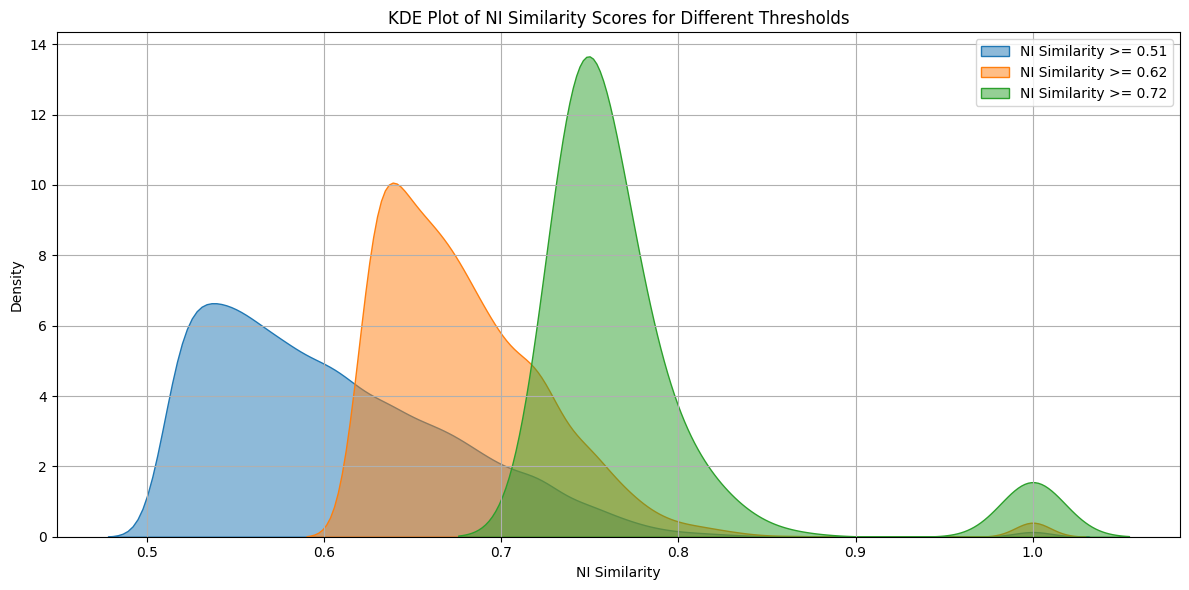

In [ ]:
#  KDE Plot of the three dfs

import seaborn as sns

# KDE plots for ni_05, ni_06, and ni_07
plt.figure(figsize=(12, 6))

sns.kdeplot(ni_05['ni_similarity'], label='NI Similarity >= 0.51', fill=True, alpha=0.5)
sns.kdeplot(ni_06['ni_similarity'], label='NI Similarity >= 0.62', fill=True, alpha=0.5)
sns.kdeplot(ni_07['ni_similarity'], label='NI Similarity >= 0.72', fill=True, alpha=0.5)

plt.title('KDE Plot of NI Similarity Scores for Different Thresholds')
plt.xlabel('NI Similarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save the dataframes to your Google Drive
df_ni_filtered_1.to_csv('/content/drive/MyDrive/df_ni_filtered_1.csv', index=False)
ni_05.to_csv('/content/drive/MyDrive/ni_05.csv', index=False)
ni_06.to_csv('/content/drive/MyDrive/ni_06.csv', index=False)
ni_07.to_csv('/content/drive/MyDrive/ni_07.csv', index=False)
